In [1]:
# warning ignore
import warnings
warnings.filterwarnings("ignore")

# Comando para recargar cambios en librerias automaticamente.
%load_ext autoreload 
%autoreload 2
import sys, os
from pathlib import Path
sys.path.append(os.path.abspath(os.path.join('..')))

# Librerias Locales del Repositorio.
from watermark.features import Utilities, Encription_images
from watermark.dataset import DataHandler

# Librerias de Python
import matplotlib.pyplot as plt  # Visualización de gráficos
import numpy as np  # Operaciones con arrays y matemáticas
import random
import os
import json

# Librerias de Procesamiento de Imagenes
import pywt  # Wavelet transform
from scipy.fftpack import dct
from imagehash import phash  # Librería para hash perceptual

# Librerias de Machine Learning
from PIL import Image
import torch
from torchvision import models




2025-02-16 22:24:00.057 | INFO     | watermark.config:<module>:11 - PROJ_ROOT path is: D:\01_PosGrado_TEC\05_Ene_Mar_2025\00_PI\01_Reto\00_WM


In [2]:
# Cargar datos de la base de datos
# Cargamos los datos.
dh = DataHandler() # Objeto manejador de datos.
data_dict = dh.load_data(Path("../data/raw"), "emothaw_data.pkl")

2025-02-16 22:24:21.582 | INFO     | watermark.dataset:load_data:54 - Loading data from ..\data\raw\emothaw_data.pkl
2025-02-16 22:24:21.830 | SUCCESS  | watermark.dataset:load_data:59 - Data loaded successfully from ..\data\raw\emothaw_data.pkl


In [3]:
# Obtener los datos de interes del dataset.
x_data_in = {} # Diccionario de Puntos en X por tarea.
y_data_in = {} # Diccionario de Puntos en Y por Tarea.
p_data_in = {} # Diccionario de Presion en cada momento por tarea.
for key in data_dict.keys():
    x_data_in[key] = [serie.X for serie in data_dict[key]] 
    y_data_in[key] = [serie.Y for serie in data_dict[key]] 
    p_data_in[key] = [serie.Pressure for serie in data_dict[key]]

In [4]:
names_list = list(data_dict.keys())
list_data_x = [x_data_in[key] for key in names_list]
list_data_y = [y_data_in[key] for key in names_list]
list_data_p = [p_data_in[key] for key in names_list]
print("Número de Usuarios:", len(list_data_x))
print("Número de Tareas realizadas:", len(list_data_x[0]))
print("Número de Muestras por Tarea:", len(list_data_x[0][0]))

Número de Usuarios: 7
Número de Tareas realizadas: 129
Número de Muestras por Tarea: 1474


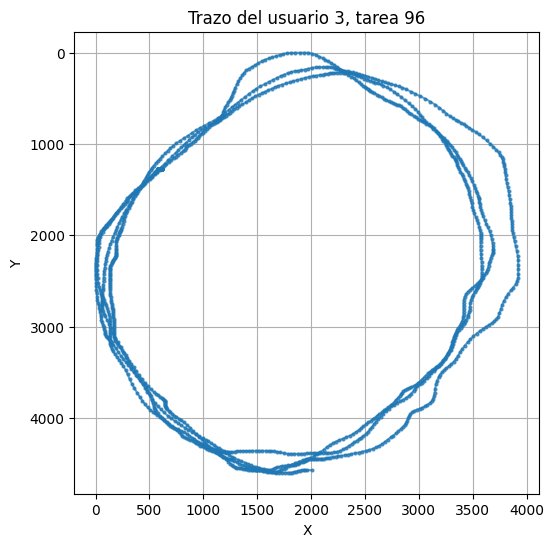

In [5]:
# Elegir un usuario y una tarea al azar (por ejemplo, el primero)
usuario_idx = random.randint(0, len(list_data_x) - 1)  
tarea_idx = random.randint(0, len(list_data_x[usuario_idx]) - 1) 

# Obtener las coordenadas del trazo
x_trazo = np.array(list_data_x[usuario_idx][tarea_idx])
y_trazo = np.array(list_data_y[usuario_idx][tarea_idx])

# Graficar el trazo
plt.figure(figsize=(6, 6))
plt.plot(x_trazo, y_trazo, marker='o', linestyle='-', markersize=2, alpha=0.7)
plt.gca().invert_yaxis()  # Invertir eje Y para que coincida con coordenadas de pantallas táctiles
plt.title(f"Trazo del usuario {usuario_idx}, tarea {tarea_idx}")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

In [6]:
# Cargar el modelo ResNet101 preentrenado
resnet101 = models.resnet101(pretrained=True)

# Remover la capa final de clasificación (la capa fc)
resnet101 = torch.nn.Sequential(*list(resnet101.children())[:-1])

resnet101.eval()  # Poner el modelo en modo evaluación

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [7]:
# Lista para almacenar las imágenes preprocesadas
imagenes_preprocesadas = []

# Recorrer todos los usuarios y tareas, estandarizando y preprocesando las imágenes
for usuario_idx in range(len(list_data_x)):
    for tarea_idx in range(len(list_data_x[usuario_idx])):
        # Obtener el trazo de un usuario y tarea específicos
        x_trazo = np.array(list_data_x[usuario_idx][tarea_idx])
        y_trazo = np.array(list_data_y[usuario_idx][tarea_idx])
        
        # Convertir el trazo a imagen
        img = dh.trazo_a_imagen_v2(x_trazo, y_trazo)

        # Preprocesar la imagen para ResNet101
        img_tensor = dh.preprocesar_imagen_tensor(img)
        
        # Añadir la imagen preprocesada a la lista
        imagenes_preprocesadas.append(img_tensor)

# Ver el tamaño de las imágenes preprocesadas
print(f"Cantidad de imágenes preprocesadas: {len(imagenes_preprocesadas)}")

Cantidad de imágenes preprocesadas: 902


In [8]:
imagenes_preprocesadas[0].shape

torch.Size([1, 3, 224, 224])

# Extracción de características de la imagen (Feature Vector Extraction)

In [9]:
# Lista para almacenar los vectores de características
feature_vectors = []

# Desactivar el cálculo de gradientes para la inferencia
with torch.no_grad():
    # Iterar sobre todas las imágenes preprocesadas
    for img_tensor in imagenes_preprocesadas:        
        # Pasar la imagen a través del modelo para obtener las características
        feature_map = resnet101(img_tensor)  # Salida de las capas convolucionales y pooling
        
        # Aplanar el tensor de características para obtener el vector de características
        feature_vector = feature_map.view(feature_map.size(0), -1)  # Aplanar a un vector de 2048 dimensiones
        
        # Añadir el vector de características a la lista
        feature_vectors.append(feature_vector)

print(f"Deep feature de la imagen 1: {feature_vectors[0]}")

Deep feature de la imagen 1: tensor([[0.6986, 0.3350, 0.0146,  ..., 2.2949, 0.0278, 0.0905]])


# Uso de DWT, DCT y Hash perceptual

In [10]:
# Lista para almacenar los vectores de características con DWT, DCT y hash perceptual
feature_vectors_dwt_dct_hash = []

# Desactivar el cálculo de gradientes para la inferencia
with torch.no_grad():
    # Iterar sobre cada vector de características (tienes 902 vectores)
    for idx, feature_vector in enumerate(feature_vectors):        
        # Aplicar DWT sobre el vector de características (usando una transformación 1D)
        coeffs = pywt.dwt(feature_vector.squeeze().cpu().numpy(), 'db1')  # 'db1' es un tipo de wavelet común (Daubechies)
        cA, cD = coeffs  # Coeficientes aproximados (cA) y detalles (cD)
        
        # Aplicar DCT sobre los coeficientes aproximados (cA)
        cA_dct = dct(cA, norm='ortho')
        
        # Extraer los primeros 64 coeficientes válidos de la DCT
        low_freq_coeffs = cA_dct[:64].reshape(8,8)  # Tomamos los primeros 32 coeficientes
        
        # Normalizar los coeficientes para que estén en [0, 255] y convertir a uint8
        low_freq_matrix_norm = np.uint8(np.interp(low_freq_coeffs, 
                                                  (low_freq_coeffs.min(), low_freq_coeffs.max()), 
                                                  (0, 255)))

        # Convertir la matriz en imagen PIL
        img = Image.fromarray(low_freq_matrix_norm, mode="L")  

        # Aplicar el perceptual hash con un tamaño mayor (32x32 bits)
        ph = phash(img, hash_size=32)  

        # Convertir el hash en una matriz 32x32
        hash_matrix = np.array(ph.hash, dtype=int)

        # Guardar el hash en formato de matriz
        feature_vectors_dwt_dct_hash.append(hash_matrix)

Comprobación del largo de las caracteristicas obtenidas.

In [11]:
len(feature_vectors_dwt_dct_hash) # Deberías tener 902 hashes perceptuales (confirmacion de hashes creados)

902

Una vez que los coeficientes válidos de la DCT han sido extraídos, se aplico un algoritmo de perceptual hashing para obtener un vector de características único y robusto para cada imagen. 
Este hash perceptual representará de manera compacta las características relevantes de la imagen.

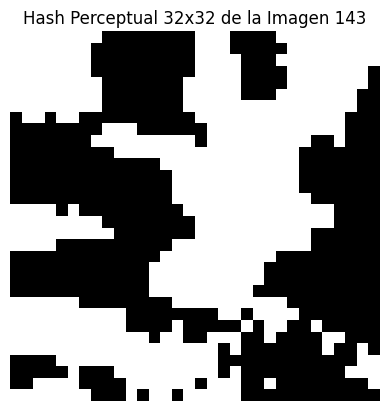

In [12]:
# Seleccionar un hash de ejemplo y visualizarlo
ejemplo_idx =   random.randint(0,902)# Puedes cambiar el índice para ver otro hash
plt.imshow(feature_vectors_dwt_dct_hash[ejemplo_idx], cmap="gray")
plt.title(f"Hash Perceptual 32x32 de la Imagen {ejemplo_idx+1}")
plt.axis("off")
plt.show()



# Watermark Image

In [13]:
util = Utilities() # Objeto de utilidades de features.
    

### Fecha a imagen cambiando a binario y despues haciendolo imagen la fecha binarizada

Fecha a Utilizar:  2016/12/15 10:12:27


(-0.5, 7.5, 7.5, -0.5)

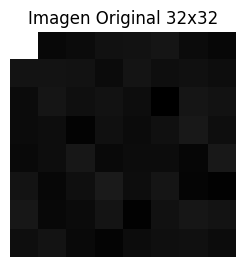

In [14]:
# Generamos Fechas Aleatorias ejemplo para hacer la funcion
date = util.dates_generator(1)[0]
print('Fecha a Utilizar: ', date)


binario = ''.join(format(ord(c), '08b') for c in date)  # 8 bits por carácter

# 2. Asegurar que tenemos 1024 bits (32x32)
faltantes = 1024 - len(binario)
if faltantes > 0:
    binario += ''.join(str(b) for b in np.random.randint(0, 2, faltantes))  # Rellenar con 0 y 1 aleatorio

# Convertir a matriz 32x32
bit_array = np.array([int(b) for b in binario[:1024]]).reshape(32, 32) 
bit_array= np.where(bit_array== 1,255, 0)  # Convertir a escala de grises

# 3. Crear imagen a partir de la matriz de bits
fecha_image = Image.fromarray(np.uint8(bit_array), mode="L")

# Mostrar la imagen original
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Imagen Original 32x32")
plt.axis("off")

### Uso de logistic chaotic map para cirfar la imagen asi como el guardado de los indices de permutacion para poder decrifrar posteriormente,

Forma de la imagen cifrada: (32, 32)


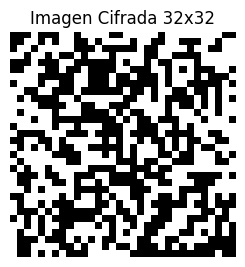

In [15]:
# Aplicar el cifrado caótico
encrypted_img, _ = util.logistic_map_encrypt(bit_array)

# Verificar forma de la imagen
print("Forma de la imagen cifrada:", encrypted_img.shape)

# Mostrar la imagen cifrada
plt.subplot(1, 2, 2)
plt.imshow(encrypted_img, cmap="gray")
plt.title("Imagen Cifrada 32x32")
plt.axis("off")
plt.show()

# Embedding del Zero Watermark

In [16]:
# Definir la carpeta donde se guardarán las claves secretas
output_folder = "logical_secret_keys"
os.makedirs(output_folder, exist_ok=True)

# Imagenes de la fecha encriptadas

In [17]:
encript = Encription_images() # Objeto de encriptacion de imagenes.
encrypted_arr_images, stored_chaos_indices=encript.generate_encrypted_date_images(len(feature_vectors_dwt_dct_hash))

### Operacion XOR para obtener logical secret keys 

In [18]:
secret_keys = {}  # Diccionario para almacenar las claves secretas
for idx, (phash_matrix, encrypted_tuple) in enumerate(zip(feature_vectors_dwt_dct_hash, encrypted_arr_images)):
    # Extraer solo la imagen encriptada (segundo elemento de la tupla)
    encrypted_img = encrypted_tuple[2]

    # Convertir la imagen de PIL a un array NumPy en escala de grises
    encrypted_img = np.array(encrypted_img, dtype=np.uint8)
    phash_matrix = np.array(phash_matrix, dtype=np.uint8)

    # Asegurar que las dimensiones coinciden
    if encrypted_img.shape != phash_matrix.shape:
        raise ValueError(f"Dimensiones incompatibles: {phash_matrix.shape} vs {encrypted_img.shape}")

    # Aplicar XOR para generar la Logical Secret Key
    logical_secret_key = np.bitwise_xor(encrypted_img, phash_matrix)
    
    # Convertir la clave en una lista para JSON
    secret_keys[f"secret_key_{idx+1}"] = logical_secret_key.tolist()

# Guardar las claves en un archivo JSON
key_json_path = os.path.join(output_folder, "secret_keys.json")
with open(key_json_path, "w") as json_file:
    json.dump(secret_keys, json_file, indent=4)

print(f"Claves secretas guardadas en {key_json_path}")


Claves secretas guardadas en logical_secret_keys\secret_keys.json


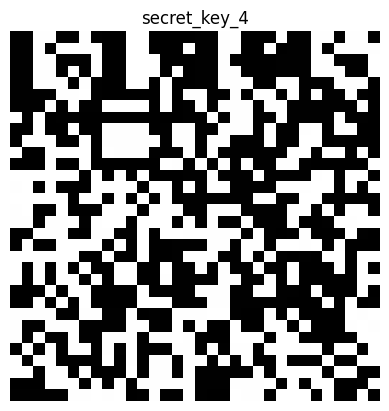

In [19]:
# Ruta del archivo JSON
key_json_path = "logical_secret_keys/secret_keys.json"

# Cargar el JSON
with open(key_json_path, "r") as json_file:
    secret_keys = json.load(json_file)

# Imprimir una clave específica (por ejemplo, "secret_key_1")
key_name = "secret_key_4"
if key_name in secret_keys:
    # Convertir la lista almacenada en el JSON a un array NumPy
    logical_secret_key = np.array(secret_keys[key_name], dtype=np.uint8)
    
    # Mostrar la imagen con matplotlib
    plt.imshow(logical_secret_key, cmap="gray")
    plt.axis("off")  # Ocultar ejes
    plt.title(key_name)
    plt.show()
else:
    print(f"La clave {key_name} no existe en el JSON.")

# Process extraction zero-watermark 

In [20]:
# Cargar las claves secretas
key_json_path = os.path.join(output_folder, "secret_keys.json")
with open(key_json_path, "r") as json_file:
    secret_keys = json.load(json_file)

# Lista para almacenar las imágenes encriptadas reconstruidas
recovered_encrypted_images = []

for idx, (phash_matrix) in enumerate(feature_vectors_dwt_dct_hash):
    # Obtener la clave secreta correspondiente
    logical_secret_key = np.array(secret_keys[f"secret_key_{idx+1}"], dtype=np.uint8)
    phash_matrix = np.array(phash_matrix, dtype=np.uint8)

    # Asegurar que las dimensiones coinciden
    if logical_secret_key.shape != phash_matrix.shape:
        raise ValueError(f"Dimensiones incompatibles: {logical_secret_key.shape} vs {phash_matrix.shape}")

    # Aplicar XOR para recuperar la imagen encriptada
    encrypted_img = np.bitwise_xor(logical_secret_key, phash_matrix)

    # Convertir de array a imagen PIL y agregar a la lista
    recovered_encrypted_images.append((idx, Image.fromarray(encrypted_img)))

print("Imágenes encriptadas recuperadas exitosamente.")

Imágenes encriptadas recuperadas exitosamente.


In [21]:
recovered_encrypted_images[0]

(0, <PIL.Image.Image image mode=L size=32x32>)

In [22]:
# Ajuste para integrar recovered_encrypted_images con logistic_map_decrypt
recovered_decrypted_images = []

for idx, encrypted_pil_img in recovered_encrypted_images:
    # Convertir la imagen recuperada en un array NumPy
    encrypted_matrix = np.array(encrypted_pil_img, dtype=np.uint8)
    

    # Cargar el chaos_idx correspondiente (esto depende de cómo lo almacenaste)
    chaos_idx = np.array(stored_chaos_indices[idx])  # Se asume que tienes un diccionario con los índices de permutación

    # Aplicar descifrado con Logistic Map
    decrypted_matrix = encript.logistic_map_decrypt(encrypted_matrix, chaos_idx)

    # Convertir de nuevo a imagen PIL
    decrypted_pil_img = Image.fromarray(decrypted_matrix)

    # Almacenar la imagen descifrada
    recovered_decrypted_images.append((idx, decrypted_pil_img))

print("Imágenes descifradas exitosamente.")

Imágenes descifradas exitosamente.


## Comparacion fecha desencriptada vs fecha usada para la marca de agua 

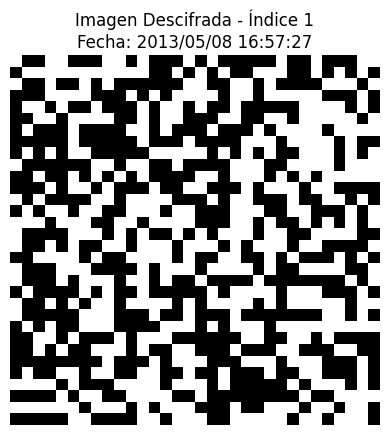

Índice fecha cifrada: 1, Fecha: 2013/05/08 16:57:27

Las fechas coinciden.


In [23]:
# Seleccionar la primera imagen descifrada

if recovered_decrypted_images:
    idx, decrypted_pil_img = recovered_decrypted_images[1]  # Obtener la primera imagen descifrada
    
    # Buscar la fecha asociada al índice en encrypted_arr_images
    original_date = None
    for enc_idx, date, _, _ in encrypted_arr_images:
        if enc_idx == idx:
            original_date = date
            break

    # Mostrar la imagen descifrada
    plt.imshow(decrypted_pil_img, cmap='gray')
    plt.title(f'Imagen Descifrada - Índice {idx}\nFecha: {original_date}')
    plt.axis('off')
    plt.show()
else:
    print("No hay imágenes descifradas disponibles.")

 # Cargar el archivo JSON
with open("generated_data.json", "r") as f:
    data = json.load(f)

# Obtener la primera fecha
first_idx = list(data["dates"].keys())[1]  # Obtener la primera clave (índice)
first_date = data["dates"][first_idx]  # Obtener la fecha correspondiente

# Imprimir la primera fecha
print(f"Índice fecha cifrada: {first_idx}, Fecha: {first_date}\n")

if first_date == original_date: # Comparar la fecha original con la descifrada
    print("Las fechas coinciden.")
else:
    print("Las fechas no coinciden.")   # Imprimir mensaje si las fechas no coinciden
